In [1]:
import json
import pandas as pd
import numpy as np
import re
import torch
import torch.autograd as autograd
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import datetime
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image
from sklearn.model_selection import train_test_split

In [2]:
# Read data from file:
with open('problems.json', 'r') as fp:
    problems_dict = json.load(fp)

In [3]:
# Process data
df = pd.DataFrame.from_dict(problems_dict, orient = 'index')
df.isna().sum()

problem_name     0
info             0
url              0
moves           22
dtype: int64

In [4]:
df = df.dropna()

In [5]:
def move_coordinate(d):
    # convert a move to the coorindates of the hold on the board
    s_split = re.split('(\d+)', d['Description'], maxsplit=1)
    # extra `-1` in both for 0 indexing
    w = ord(s_split[0].upper()) - 64 - 1
    h = int(s_split[1]) - 1
    
    return (h, w, 0)


def convert_moves(moves):
    array = np.zeros((18, 11, 1))
    for move in moves:
        array[move_coordinate(move)] = 1
    return array


df['Moves_array'] = df['moves'].apply(convert_moves)
problems = list(df['Moves_array'])
len(problems)

14902

In [6]:
problems = np.moveaxis(problems, -1, 1)
problems = problems.astype(np.float32)


In [7]:
# Process labels
grades = []
for problem in df['info']:
    grades.append(problem[2])
    
grade_map = {
        '5+':0,
        '6A': 1,
        '6A+': 2,
        '6B': 3,
        '6B+': 4,
        '6C': 5,
        '6C+': 6,
        '7A': 7,
        '7A+': 8,
        '7B': 9,
        '7B+': 10,
        '7C': 11,
        '7C+': 12,
        '8A': 13,
        '8A+': 14,
        '8B': 15,
        '8B+': 16,
        '8C': 17,
        '8C+': 18
    }

grades = [grade.split()[0] for grade in grades]
grades = [grade_map[grade] for grade in grades]
len(grades)

14902

In [8]:
class ProblemDataset(Dataset):
    def __init__(self, data, label, transform=None):
        self.data = data
        self.transform = transform
        self.label = label
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        image_tensor = torch.from_numpy(image)
        
        
        
        
            
        label = self.label[idx]
        
        
        target = torch.tensor(label,dtype=torch.long)
        
        return image_tensor, target

In [9]:
X_train, X_test, y_train, y_test = train_test_split(problems, grades, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)


In [10]:
train = ProblemDataset(X_train, y_train)
val = ProblemDataset(X_val, y_val)
test = ProblemDataset(X_test, y_test)

In [11]:
batch_size = 128

In [12]:
train_loader = DataLoader(train, batch_size=16)
val_loader = DataLoader(val, batch_size=16)
test_loader = DataLoader(test, batch_size=16)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [47]:
import os
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image


# changed configuration to this instead of argparse for easier interaction
CUDA = True
SEED = 1
BATCH_SIZE = 16
LOG_INTERVAL = 10
EPOCHS = 100
no_of_sample = 10

# connections through the autoencoder bottleneck
# in the pytorch VAE example, this is 20
ZDIMS = 20

torch.manual_seed(SEED)
if CUDA:
    torch.cuda.manual_seed(SEED)






class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(4, 4), padding=(10, 7),
                               stride=2)  # This padding keeps the size of the image same, i.e. same padding
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(4, 4), padding=(10, 7), stride=2)
        self.fc11 = nn.Linear(in_features=128 * 18 * 11, out_features=1024)
        self.fc12 = nn.Linear(in_features=1024, out_features=ZDIMS)

        self.fc21 = nn.Linear(in_features=128 * 18 * 11, out_features=1024)
        self.fc22 = nn.Linear(in_features=1024, out_features=ZDIMS)
        self.relu = nn.ReLU()

        # For decoder

        # For mu
        self.fc1 = nn.Linear(in_features=20, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=7 * 7 * 128)
        self.conv_t1 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, padding=1, stride=2)
        self.conv_t2 = nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=(7,2), padding=(1,2), stride=1)



    def encode(self, x: Variable) -> (Variable, Variable):

        x = x.view(-1, 1, 18, 11)
        x = F.elu(self.conv1(x))
        x = F.elu(self.conv2(x))
        x = x.view(-1, 128 * 18 * 11)

        mu_z = F.elu(self.fc11(x))
        mu_z = self.fc12(mu_z)

        logvar_z = F.elu(self.fc21(x))
        logvar_z = self.fc22(logvar_z)

        return mu_z, logvar_z


    def reparameterize(self, mu: Variable, logvar: Variable) -> Variable:


        if self.training:
            # multiply log variance with 0.5, then in-place exponent
            # yielding the standard deviation

            sample_z = []
            for _ in range(no_of_sample):
                std = logvar.mul(0.5).exp_()  # type: Variable
                eps = Variable(std.data.new(std.size()).normal_())
                sample_z.append(eps.mul(std).add_(mu))

            return sample_z

        else:
            # During inference, we simply spit out the mean of the
            # learned distribution for the current input.  We could
            # use a random sample from the distribution, but mu of
            # course has the highest probability.
            return mu

    def decode(self, z: Variable) -> Variable:

        x = F.elu(self.fc1(z))
        x = F.elu(self.fc2(x))
        x = x.view(-1, 128, 7, 7)
        x = F.relu(self.conv_t1(x))
        x = F.sigmoid(self.conv_t2(x))
        return x.view(-1, 198)


    def forward(self, x: Variable) -> (Variable, Variable, Variable):
        mu, logvar = self.encode(x.view(-1, 198))
        z = self.reparameterize(mu, logvar)
        if self.training:
            return [self.decode(z) for z in z], mu, logvar
        else:
            return self.decode(z), mu, logvar
        # return self.decode(z), mu, logvar

    def loss_function(self, recon_x, x, mu, logvar) -> Variable:
        # how well do input x and output recon_x agree?

        if self.training:
            BCE = 0
            for recon_x_one in recon_x:
                BCE += F.binary_cross_entropy(recon_x_one, x.view(-1, 198))
            BCE /= len(recon_x)
        else:
            BCE = F.binary_cross_entropy(recon_x, x.view(-1, 198))

        # KLD is Kullback–Leibler divergence -- how much does one learned
        # distribution deviate from another, in this specific case the
        # learned distribution from the unit Gaussian

        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # https://arxiv.org/abs/1312.6114
        # - D_{KL} = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        # note the negative D_{KL} in appendix B of the paper
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        # Normalise by same number of elements as in reconstruction
        KLD /= BATCH_SIZE * 198


        return BCE + KLD


model = VAE()
if CUDA:
    model.cuda()





optimizer = optim.Adam(model.parameters(), lr=1e-4)


def train(epoch):
    # toggle model to train mode
    model.train()
    train_loss = 0
    # in the case of MNIST, len(train_loader.dataset) is 60000
    # each `data` is of BATCH_SIZE samples and has shape [128, 1, 28, 28]
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        
        if CUDA:
            data = data.cuda()
        optimizer.zero_grad()

        # push whole batch of data through VAE.forward() to get recon_loss
        recon_batch, mu, logvar = model(data)
        # calculate scalar loss
        loss = model.loss_function(recon_batch, data, mu, logvar)
        # calculate the gradient of the loss w.r.t. the graph leaves
        # i.e. input variables -- by the power of pytorch!
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader),
                       loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0

    # each data is of BATCH_SIZE (default 128) samples
    for i, (data, _) in enumerate(test_loader):
        if CUDA:
            # make sure this lives on the GPU
            data = data.cuda()

        # we're only going to infer, so no autograd at all required: volatile=True
        data = Variable(data, volatile=True)
        recon_batch, mu, logvar = model(data)
        test_loss += model.loss_function(recon_batch, data, mu, logvar).item()
        if i == 0:
            n = min(data.size(0), 8)
            # for the first 128 batch of the epoch, show the first 8 input digits
            # with right below them the reconstructed output digits
            comparison = torch.cat([data[:n],
                                    recon_batch.view(BATCH_SIZE, 1, 18, 11)[:n]])
            save_image(comparison.data.cpu(),
                       'reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [48]:
for epoch in range(1, EPOCHS + 1):
        train(epoch)
        test(epoch)

        # 64 sets of random ZDIMS-float vectors, i.e. 64 locations / MNIST
        # digits in latent space
        sample = Variable(torch.randn(64, ZDIMS))
        if CUDA:
            sample = sample.cuda()
        sample = model.decode(sample).cpu()

        # save out as an 8x8 matrix of MNIST digits
        # this will give you a visual idea of how well latent space can generate things
        # that look like digits
        save_image(sample.data.view(64, 1, 18, 11),'reconstruction' + str(epoch) + '.png')

Train Epoch: 1 [0/8940 (0%)]	Loss: 0.054762
Train Epoch: 1 [160/8940 (2%)]	Loss: 0.022958
Train Epoch: 1 [320/8940 (4%)]	Loss: 0.013715
Train Epoch: 1 [480/8940 (5%)]	Loss: 0.011717
Train Epoch: 1 [640/8940 (7%)]	Loss: 0.011218
Train Epoch: 1 [800/8940 (9%)]	Loss: 0.011800
Train Epoch: 1 [960/8940 (11%)]	Loss: 0.011654
Train Epoch: 1 [1120/8940 (13%)]	Loss: 0.011507
Train Epoch: 1 [1280/8940 (14%)]	Loss: 0.012196
Train Epoch: 1 [1440/8940 (16%)]	Loss: 0.010592
Train Epoch: 1 [1600/8940 (18%)]	Loss: 0.010956
Train Epoch: 1 [1760/8940 (20%)]	Loss: 0.011309
Train Epoch: 1 [1920/8940 (21%)]	Loss: 0.010538
Train Epoch: 1 [2080/8940 (23%)]	Loss: 0.010573
Train Epoch: 1 [2240/8940 (25%)]	Loss: 0.011769
Train Epoch: 1 [2400/8940 (27%)]	Loss: 0.010376
Train Epoch: 1 [2560/8940 (29%)]	Loss: 0.010984
Train Epoch: 1 [2720/8940 (30%)]	Loss: 0.010437
Train Epoch: 1 [2880/8940 (32%)]	Loss: 0.010784
Train Epoch: 1 [3040/8940 (34%)]	Loss: 0.010771
Train Epoch: 1 [3200/8940 (36%)]	Loss: 0.010092
Train E

C:\Users\Tom\Anaconda3\lib\site-packages\ipykernel_launcher.py:193: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


====> Test set loss: 0.0087
Train Epoch: 2 [0/8940 (0%)]	Loss: 0.009591
Train Epoch: 2 [160/8940 (2%)]	Loss: 0.009326
Train Epoch: 2 [320/8940 (4%)]	Loss: 0.009046
Train Epoch: 2 [480/8940 (5%)]	Loss: 0.008845
Train Epoch: 2 [640/8940 (7%)]	Loss: 0.008780
Train Epoch: 2 [800/8940 (9%)]	Loss: 0.009475
Train Epoch: 2 [960/8940 (11%)]	Loss: 0.009403
Train Epoch: 2 [1120/8940 (13%)]	Loss: 0.009644
Train Epoch: 2 [1280/8940 (14%)]	Loss: 0.010435
Train Epoch: 2 [1440/8940 (16%)]	Loss: 0.008937
Train Epoch: 2 [1600/8940 (18%)]	Loss: 0.009016
Train Epoch: 2 [1760/8940 (20%)]	Loss: 0.010044
Train Epoch: 2 [1920/8940 (21%)]	Loss: 0.008833
Train Epoch: 2 [2080/8940 (23%)]	Loss: 0.009146
Train Epoch: 2 [2240/8940 (25%)]	Loss: 0.009887
Train Epoch: 2 [2400/8940 (27%)]	Loss: 0.009261
Train Epoch: 2 [2560/8940 (29%)]	Loss: 0.009872
Train Epoch: 2 [2720/8940 (30%)]	Loss: 0.009430
Train Epoch: 2 [2880/8940 (32%)]	Loss: 0.009944
Train Epoch: 2 [3040/8940 (34%)]	Loss: 0.009485
Train Epoch: 2 [3200/8940 (

====> Epoch: 4 Average loss: 0.0090
====> Test set loss: 0.0077
Train Epoch: 5 [0/8940 (0%)]	Loss: 0.009095
Train Epoch: 5 [160/8940 (2%)]	Loss: 0.008779
Train Epoch: 5 [320/8940 (4%)]	Loss: 0.008717
Train Epoch: 5 [480/8940 (5%)]	Loss: 0.008431
Train Epoch: 5 [640/8940 (7%)]	Loss: 0.008287
Train Epoch: 5 [800/8940 (9%)]	Loss: 0.009048
Train Epoch: 5 [960/8940 (11%)]	Loss: 0.008920
Train Epoch: 5 [1120/8940 (13%)]	Loss: 0.008982
Train Epoch: 5 [1280/8940 (14%)]	Loss: 0.010306
Train Epoch: 5 [1440/8940 (16%)]	Loss: 0.008750
Train Epoch: 5 [1600/8940 (18%)]	Loss: 0.008734
Train Epoch: 5 [1760/8940 (20%)]	Loss: 0.009887
Train Epoch: 5 [1920/8940 (21%)]	Loss: 0.008299
Train Epoch: 5 [2080/8940 (23%)]	Loss: 0.008695
Train Epoch: 5 [2240/8940 (25%)]	Loss: 0.009550
Train Epoch: 5 [2400/8940 (27%)]	Loss: 0.008931
Train Epoch: 5 [2560/8940 (29%)]	Loss: 0.009595
Train Epoch: 5 [2720/8940 (30%)]	Loss: 0.009079
Train Epoch: 5 [2880/8940 (32%)]	Loss: 0.009835
Train Epoch: 5 [3040/8940 (34%)]	Loss: 

Train Epoch: 7 [8800/8940 (98%)]	Loss: 0.008300
====> Epoch: 7 Average loss: 0.0089
====> Test set loss: 0.0075
Train Epoch: 8 [0/8940 (0%)]	Loss: 0.008973
Train Epoch: 8 [160/8940 (2%)]	Loss: 0.008539
Train Epoch: 8 [320/8940 (4%)]	Loss: 0.008504
Train Epoch: 8 [480/8940 (5%)]	Loss: 0.008155
Train Epoch: 8 [640/8940 (7%)]	Loss: 0.008253
Train Epoch: 8 [800/8940 (9%)]	Loss: 0.009046
Train Epoch: 8 [960/8940 (11%)]	Loss: 0.008772
Train Epoch: 8 [1120/8940 (13%)]	Loss: 0.008743
Train Epoch: 8 [1280/8940 (14%)]	Loss: 0.010112
Train Epoch: 8 [1440/8940 (16%)]	Loss: 0.008527
Train Epoch: 8 [1600/8940 (18%)]	Loss: 0.008491
Train Epoch: 8 [1760/8940 (20%)]	Loss: 0.009782
Train Epoch: 8 [1920/8940 (21%)]	Loss: 0.008255
Train Epoch: 8 [2080/8940 (23%)]	Loss: 0.008665
Train Epoch: 8 [2240/8940 (25%)]	Loss: 0.009445
Train Epoch: 8 [2400/8940 (27%)]	Loss: 0.008961
Train Epoch: 8 [2560/8940 (29%)]	Loss: 0.009417
Train Epoch: 8 [2720/8940 (30%)]	Loss: 0.009002
Train Epoch: 8 [2880/8940 (32%)]	Loss: 

Train Epoch: 10 [8480/8940 (95%)]	Loss: 0.009719
Train Epoch: 10 [8640/8940 (97%)]	Loss: 0.008646
Train Epoch: 10 [8800/8940 (98%)]	Loss: 0.008272
====> Epoch: 10 Average loss: 0.0088
====> Test set loss: 0.0074
Train Epoch: 11 [0/8940 (0%)]	Loss: 0.008875
Train Epoch: 11 [160/8940 (2%)]	Loss: 0.008509
Train Epoch: 11 [320/8940 (4%)]	Loss: 0.008497
Train Epoch: 11 [480/8940 (5%)]	Loss: 0.008017
Train Epoch: 11 [640/8940 (7%)]	Loss: 0.008077
Train Epoch: 11 [800/8940 (9%)]	Loss: 0.008948
Train Epoch: 11 [960/8940 (11%)]	Loss: 0.008892
Train Epoch: 11 [1120/8940 (13%)]	Loss: 0.008724
Train Epoch: 11 [1280/8940 (14%)]	Loss: 0.010087
Train Epoch: 11 [1440/8940 (16%)]	Loss: 0.008504
Train Epoch: 11 [1600/8940 (18%)]	Loss: 0.008578
Train Epoch: 11 [1760/8940 (20%)]	Loss: 0.009891
Train Epoch: 11 [1920/8940 (21%)]	Loss: 0.008067
Train Epoch: 11 [2080/8940 (23%)]	Loss: 0.008570
Train Epoch: 11 [2240/8940 (25%)]	Loss: 0.009391
Train Epoch: 11 [2400/8940 (27%)]	Loss: 0.008961
Train Epoch: 11 [25

Train Epoch: 13 [7840/8940 (88%)]	Loss: 0.008415
Train Epoch: 13 [8000/8940 (89%)]	Loss: 0.009066
Train Epoch: 13 [8160/8940 (91%)]	Loss: 0.008721
Train Epoch: 13 [8320/8940 (93%)]	Loss: 0.008894
Train Epoch: 13 [8480/8940 (95%)]	Loss: 0.009655
Train Epoch: 13 [8640/8940 (97%)]	Loss: 0.008632
Train Epoch: 13 [8800/8940 (98%)]	Loss: 0.008151
====> Epoch: 13 Average loss: 0.0087
====> Test set loss: 0.0073
Train Epoch: 14 [0/8940 (0%)]	Loss: 0.008747
Train Epoch: 14 [160/8940 (2%)]	Loss: 0.008545
Train Epoch: 14 [320/8940 (4%)]	Loss: 0.008453
Train Epoch: 14 [480/8940 (5%)]	Loss: 0.008090
Train Epoch: 14 [640/8940 (7%)]	Loss: 0.008045
Train Epoch: 14 [800/8940 (9%)]	Loss: 0.008871
Train Epoch: 14 [960/8940 (11%)]	Loss: 0.008793
Train Epoch: 14 [1120/8940 (13%)]	Loss: 0.008621
Train Epoch: 14 [1280/8940 (14%)]	Loss: 0.010014
Train Epoch: 14 [1440/8940 (16%)]	Loss: 0.008571
Train Epoch: 14 [1600/8940 (18%)]	Loss: 0.008631
Train Epoch: 14 [1760/8940 (20%)]	Loss: 0.009578
Train Epoch: 14 [19

Train Epoch: 16 [7200/8940 (81%)]	Loss: 0.008105
Train Epoch: 16 [7360/8940 (82%)]	Loss: 0.007718
Train Epoch: 16 [7520/8940 (84%)]	Loss: 0.008265
Train Epoch: 16 [7680/8940 (86%)]	Loss: 0.008994
Train Epoch: 16 [7840/8940 (88%)]	Loss: 0.008447
Train Epoch: 16 [8000/8940 (89%)]	Loss: 0.009146
Train Epoch: 16 [8160/8940 (91%)]	Loss: 0.008604
Train Epoch: 16 [8320/8940 (93%)]	Loss: 0.008879
Train Epoch: 16 [8480/8940 (95%)]	Loss: 0.009504
Train Epoch: 16 [8640/8940 (97%)]	Loss: 0.008500
Train Epoch: 16 [8800/8940 (98%)]	Loss: 0.008164
====> Epoch: 16 Average loss: 0.0087
====> Test set loss: 0.0073
Train Epoch: 17 [0/8940 (0%)]	Loss: 0.008657
Train Epoch: 17 [160/8940 (2%)]	Loss: 0.008331
Train Epoch: 17 [320/8940 (4%)]	Loss: 0.008298
Train Epoch: 17 [480/8940 (5%)]	Loss: 0.008021
Train Epoch: 17 [640/8940 (7%)]	Loss: 0.007934
Train Epoch: 17 [800/8940 (9%)]	Loss: 0.008720
Train Epoch: 17 [960/8940 (11%)]	Loss: 0.008731
Train Epoch: 17 [1120/8940 (13%)]	Loss: 0.008498
Train Epoch: 17 [12

Train Epoch: 19 [6560/8940 (73%)]	Loss: 0.007985
Train Epoch: 19 [6720/8940 (75%)]	Loss: 0.008234
Train Epoch: 19 [6880/8940 (77%)]	Loss: 0.008149
Train Epoch: 19 [7040/8940 (79%)]	Loss: 0.007912
Train Epoch: 19 [7200/8940 (81%)]	Loss: 0.008028
Train Epoch: 19 [7360/8940 (82%)]	Loss: 0.007655
Train Epoch: 19 [7520/8940 (84%)]	Loss: 0.008063
Train Epoch: 19 [7680/8940 (86%)]	Loss: 0.009063
Train Epoch: 19 [7840/8940 (88%)]	Loss: 0.008326
Train Epoch: 19 [8000/8940 (89%)]	Loss: 0.009077
Train Epoch: 19 [8160/8940 (91%)]	Loss: 0.008541
Train Epoch: 19 [8320/8940 (93%)]	Loss: 0.008773
Train Epoch: 19 [8480/8940 (95%)]	Loss: 0.009383
Train Epoch: 19 [8640/8940 (97%)]	Loss: 0.008748
Train Epoch: 19 [8800/8940 (98%)]	Loss: 0.008135
====> Epoch: 19 Average loss: 0.0086
====> Test set loss: 0.0073
Train Epoch: 20 [0/8940 (0%)]	Loss: 0.008705
Train Epoch: 20 [160/8940 (2%)]	Loss: 0.008412
Train Epoch: 20 [320/8940 (4%)]	Loss: 0.008413
Train Epoch: 20 [480/8940 (5%)]	Loss: 0.007895
Train Epoch: 2

Train Epoch: 22 [5920/8940 (66%)]	Loss: 0.008251
Train Epoch: 22 [6080/8940 (68%)]	Loss: 0.008181
Train Epoch: 22 [6240/8940 (70%)]	Loss: 0.008505
Train Epoch: 22 [6400/8940 (72%)]	Loss: 0.009541
Train Epoch: 22 [6560/8940 (73%)]	Loss: 0.007834
Train Epoch: 22 [6720/8940 (75%)]	Loss: 0.008481
Train Epoch: 22 [6880/8940 (77%)]	Loss: 0.008159
Train Epoch: 22 [7040/8940 (79%)]	Loss: 0.007869
Train Epoch: 22 [7200/8940 (81%)]	Loss: 0.007984
Train Epoch: 22 [7360/8940 (82%)]	Loss: 0.007746
Train Epoch: 22 [7520/8940 (84%)]	Loss: 0.008026
Train Epoch: 22 [7680/8940 (86%)]	Loss: 0.008884
Train Epoch: 22 [7840/8940 (88%)]	Loss: 0.008201
Train Epoch: 22 [8000/8940 (89%)]	Loss: 0.009018
Train Epoch: 22 [8160/8940 (91%)]	Loss: 0.008521
Train Epoch: 22 [8320/8940 (93%)]	Loss: 0.008792
Train Epoch: 22 [8480/8940 (95%)]	Loss: 0.009364
Train Epoch: 22 [8640/8940 (97%)]	Loss: 0.008469
Train Epoch: 22 [8800/8940 (98%)]	Loss: 0.008093
====> Epoch: 22 Average loss: 0.0086
====> Test set loss: 0.0073
Trai

Train Epoch: 25 [5280/8940 (59%)]	Loss: 0.007905
Train Epoch: 25 [5440/8940 (61%)]	Loss: 0.008275
Train Epoch: 25 [5600/8940 (63%)]	Loss: 0.008344
Train Epoch: 25 [5760/8940 (64%)]	Loss: 0.008020
Train Epoch: 25 [5920/8940 (66%)]	Loss: 0.008283
Train Epoch: 25 [6080/8940 (68%)]	Loss: 0.008192
Train Epoch: 25 [6240/8940 (70%)]	Loss: 0.008478
Train Epoch: 25 [6400/8940 (72%)]	Loss: 0.009625
Train Epoch: 25 [6560/8940 (73%)]	Loss: 0.007980
Train Epoch: 25 [6720/8940 (75%)]	Loss: 0.008393
Train Epoch: 25 [6880/8940 (77%)]	Loss: 0.007943
Train Epoch: 25 [7040/8940 (79%)]	Loss: 0.007808
Train Epoch: 25 [7200/8940 (81%)]	Loss: 0.008027
Train Epoch: 25 [7360/8940 (82%)]	Loss: 0.007821
Train Epoch: 25 [7520/8940 (84%)]	Loss: 0.008041
Train Epoch: 25 [7680/8940 (86%)]	Loss: 0.008878
Train Epoch: 25 [7840/8940 (88%)]	Loss: 0.008370
Train Epoch: 25 [8000/8940 (89%)]	Loss: 0.009058
Train Epoch: 25 [8160/8940 (91%)]	Loss: 0.008472
Train Epoch: 25 [8320/8940 (93%)]	Loss: 0.008854
Train Epoch: 25 [848

Train Epoch: 28 [4640/8940 (52%)]	Loss: 0.008807
Train Epoch: 28 [4800/8940 (54%)]	Loss: 0.008630
Train Epoch: 28 [4960/8940 (55%)]	Loss: 0.008235
Train Epoch: 28 [5120/8940 (57%)]	Loss: 0.007675
Train Epoch: 28 [5280/8940 (59%)]	Loss: 0.007861
Train Epoch: 28 [5440/8940 (61%)]	Loss: 0.008184
Train Epoch: 28 [5600/8940 (63%)]	Loss: 0.008475
Train Epoch: 28 [5760/8940 (64%)]	Loss: 0.008141
Train Epoch: 28 [5920/8940 (66%)]	Loss: 0.008311
Train Epoch: 28 [6080/8940 (68%)]	Loss: 0.008274
Train Epoch: 28 [6240/8940 (70%)]	Loss: 0.008368
Train Epoch: 28 [6400/8940 (72%)]	Loss: 0.009459
Train Epoch: 28 [6560/8940 (73%)]	Loss: 0.007952
Train Epoch: 28 [6720/8940 (75%)]	Loss: 0.008307
Train Epoch: 28 [6880/8940 (77%)]	Loss: 0.007872
Train Epoch: 28 [7040/8940 (79%)]	Loss: 0.007689
Train Epoch: 28 [7200/8940 (81%)]	Loss: 0.007922
Train Epoch: 28 [7360/8940 (82%)]	Loss: 0.007683
Train Epoch: 28 [7520/8940 (84%)]	Loss: 0.007975
Train Epoch: 28 [7680/8940 (86%)]	Loss: 0.008909
Train Epoch: 28 [784

Train Epoch: 31 [4000/8940 (45%)]	Loss: 0.008841
Train Epoch: 31 [4160/8940 (47%)]	Loss: 0.008015
Train Epoch: 31 [4320/8940 (48%)]	Loss: 0.008126
Train Epoch: 31 [4480/8940 (50%)]	Loss: 0.008498
Train Epoch: 31 [4640/8940 (52%)]	Loss: 0.008757
Train Epoch: 31 [4800/8940 (54%)]	Loss: 0.008504
Train Epoch: 31 [4960/8940 (55%)]	Loss: 0.008228
Train Epoch: 31 [5120/8940 (57%)]	Loss: 0.007561
Train Epoch: 31 [5280/8940 (59%)]	Loss: 0.007943
Train Epoch: 31 [5440/8940 (61%)]	Loss: 0.008076
Train Epoch: 31 [5600/8940 (63%)]	Loss: 0.008403
Train Epoch: 31 [5760/8940 (64%)]	Loss: 0.008078
Train Epoch: 31 [5920/8940 (66%)]	Loss: 0.008150
Train Epoch: 31 [6080/8940 (68%)]	Loss: 0.007912
Train Epoch: 31 [6240/8940 (70%)]	Loss: 0.008301
Train Epoch: 31 [6400/8940 (72%)]	Loss: 0.009505
Train Epoch: 31 [6560/8940 (73%)]	Loss: 0.007729
Train Epoch: 31 [6720/8940 (75%)]	Loss: 0.008338
Train Epoch: 31 [6880/8940 (77%)]	Loss: 0.007724
Train Epoch: 31 [7040/8940 (79%)]	Loss: 0.007754
Train Epoch: 31 [720

Train Epoch: 34 [3360/8940 (38%)]	Loss: 0.008417
Train Epoch: 34 [3520/8940 (39%)]	Loss: 0.008207
Train Epoch: 34 [3680/8940 (41%)]	Loss: 0.008372
Train Epoch: 34 [3840/8940 (43%)]	Loss: 0.008583
Train Epoch: 34 [4000/8940 (45%)]	Loss: 0.008782
Train Epoch: 34 [4160/8940 (47%)]	Loss: 0.007987
Train Epoch: 34 [4320/8940 (48%)]	Loss: 0.008021
Train Epoch: 34 [4480/8940 (50%)]	Loss: 0.008707
Train Epoch: 34 [4640/8940 (52%)]	Loss: 0.008770
Train Epoch: 34 [4800/8940 (54%)]	Loss: 0.008420
Train Epoch: 34 [4960/8940 (55%)]	Loss: 0.008290
Train Epoch: 34 [5120/8940 (57%)]	Loss: 0.007673
Train Epoch: 34 [5280/8940 (59%)]	Loss: 0.007648
Train Epoch: 34 [5440/8940 (61%)]	Loss: 0.008077
Train Epoch: 34 [5600/8940 (63%)]	Loss: 0.008328
Train Epoch: 34 [5760/8940 (64%)]	Loss: 0.008050
Train Epoch: 34 [5920/8940 (66%)]	Loss: 0.008216
Train Epoch: 34 [6080/8940 (68%)]	Loss: 0.007939
Train Epoch: 34 [6240/8940 (70%)]	Loss: 0.008363
Train Epoch: 34 [6400/8940 (72%)]	Loss: 0.009418
Train Epoch: 34 [656

Train Epoch: 37 [2720/8940 (30%)]	Loss: 0.008606
Train Epoch: 37 [2880/8940 (32%)]	Loss: 0.009190
Train Epoch: 37 [3040/8940 (34%)]	Loss: 0.008170
Train Epoch: 37 [3200/8940 (36%)]	Loss: 0.008367
Train Epoch: 37 [3360/8940 (38%)]	Loss: 0.008421
Train Epoch: 37 [3520/8940 (39%)]	Loss: 0.008115
Train Epoch: 37 [3680/8940 (41%)]	Loss: 0.008357
Train Epoch: 37 [3840/8940 (43%)]	Loss: 0.008648
Train Epoch: 37 [4000/8940 (45%)]	Loss: 0.008549
Train Epoch: 37 [4160/8940 (47%)]	Loss: 0.008091
Train Epoch: 37 [4320/8940 (48%)]	Loss: 0.007986
Train Epoch: 37 [4480/8940 (50%)]	Loss: 0.008483
Train Epoch: 37 [4640/8940 (52%)]	Loss: 0.008714
Train Epoch: 37 [4800/8940 (54%)]	Loss: 0.008483
Train Epoch: 37 [4960/8940 (55%)]	Loss: 0.008212
Train Epoch: 37 [5120/8940 (57%)]	Loss: 0.007712
Train Epoch: 37 [5280/8940 (59%)]	Loss: 0.007867
Train Epoch: 37 [5440/8940 (61%)]	Loss: 0.007904
Train Epoch: 37 [5600/8940 (63%)]	Loss: 0.008415
Train Epoch: 37 [5760/8940 (64%)]	Loss: 0.007897
Train Epoch: 37 [592

Train Epoch: 40 [2080/8940 (23%)]	Loss: 0.008024
Train Epoch: 40 [2240/8940 (25%)]	Loss: 0.008939
Train Epoch: 40 [2400/8940 (27%)]	Loss: 0.008416
Train Epoch: 40 [2560/8940 (29%)]	Loss: 0.008880
Train Epoch: 40 [2720/8940 (30%)]	Loss: 0.008577
Train Epoch: 40 [2880/8940 (32%)]	Loss: 0.009059
Train Epoch: 40 [3040/8940 (34%)]	Loss: 0.008390
Train Epoch: 40 [3200/8940 (36%)]	Loss: 0.008363
Train Epoch: 40 [3360/8940 (38%)]	Loss: 0.008423
Train Epoch: 40 [3520/8940 (39%)]	Loss: 0.008171
Train Epoch: 40 [3680/8940 (41%)]	Loss: 0.008373
Train Epoch: 40 [3840/8940 (43%)]	Loss: 0.008538
Train Epoch: 40 [4000/8940 (45%)]	Loss: 0.008625
Train Epoch: 40 [4160/8940 (47%)]	Loss: 0.008102
Train Epoch: 40 [4320/8940 (48%)]	Loss: 0.007867
Train Epoch: 40 [4480/8940 (50%)]	Loss: 0.008371
Train Epoch: 40 [4640/8940 (52%)]	Loss: 0.008623
Train Epoch: 40 [4800/8940 (54%)]	Loss: 0.008457
Train Epoch: 40 [4960/8940 (55%)]	Loss: 0.008123
Train Epoch: 40 [5120/8940 (57%)]	Loss: 0.007557
Train Epoch: 40 [528

Train Epoch: 43 [1440/8940 (16%)]	Loss: 0.008230
Train Epoch: 43 [1600/8940 (18%)]	Loss: 0.008091
Train Epoch: 43 [1760/8940 (20%)]	Loss: 0.009074
Train Epoch: 43 [1920/8940 (21%)]	Loss: 0.007525
Train Epoch: 43 [2080/8940 (23%)]	Loss: 0.008039
Train Epoch: 43 [2240/8940 (25%)]	Loss: 0.009010
Train Epoch: 43 [2400/8940 (27%)]	Loss: 0.008420
Train Epoch: 43 [2560/8940 (29%)]	Loss: 0.008769
Train Epoch: 43 [2720/8940 (30%)]	Loss: 0.008628
Train Epoch: 43 [2880/8940 (32%)]	Loss: 0.008906
Train Epoch: 43 [3040/8940 (34%)]	Loss: 0.008115
Train Epoch: 43 [3200/8940 (36%)]	Loss: 0.008318
Train Epoch: 43 [3360/8940 (38%)]	Loss: 0.008482
Train Epoch: 43 [3520/8940 (39%)]	Loss: 0.008041
Train Epoch: 43 [3680/8940 (41%)]	Loss: 0.008174
Train Epoch: 43 [3840/8940 (43%)]	Loss: 0.008596
Train Epoch: 43 [4000/8940 (45%)]	Loss: 0.008614
Train Epoch: 43 [4160/8940 (47%)]	Loss: 0.007850
Train Epoch: 43 [4320/8940 (48%)]	Loss: 0.007979
Train Epoch: 43 [4480/8940 (50%)]	Loss: 0.008433
Train Epoch: 43 [464

Train Epoch: 46 [800/8940 (9%)]	Loss: 0.008466
Train Epoch: 46 [960/8940 (11%)]	Loss: 0.008187
Train Epoch: 46 [1120/8940 (13%)]	Loss: 0.008274
Train Epoch: 46 [1280/8940 (14%)]	Loss: 0.009449
Train Epoch: 46 [1440/8940 (16%)]	Loss: 0.008150
Train Epoch: 46 [1600/8940 (18%)]	Loss: 0.007971
Train Epoch: 46 [1760/8940 (20%)]	Loss: 0.009057
Train Epoch: 46 [1920/8940 (21%)]	Loss: 0.007644
Train Epoch: 46 [2080/8940 (23%)]	Loss: 0.008005
Train Epoch: 46 [2240/8940 (25%)]	Loss: 0.008840
Train Epoch: 46 [2400/8940 (27%)]	Loss: 0.008516
Train Epoch: 46 [2560/8940 (29%)]	Loss: 0.008754
Train Epoch: 46 [2720/8940 (30%)]	Loss: 0.008326
Train Epoch: 46 [2880/8940 (32%)]	Loss: 0.008905
Train Epoch: 46 [3040/8940 (34%)]	Loss: 0.007990
Train Epoch: 46 [3200/8940 (36%)]	Loss: 0.008398
Train Epoch: 46 [3360/8940 (38%)]	Loss: 0.008132
Train Epoch: 46 [3520/8940 (39%)]	Loss: 0.007929
Train Epoch: 46 [3680/8940 (41%)]	Loss: 0.008279
Train Epoch: 46 [3840/8940 (43%)]	Loss: 0.008533
Train Epoch: 46 [4000/8

Train Epoch: 49 [0/8940 (0%)]	Loss: 0.008232
Train Epoch: 49 [160/8940 (2%)]	Loss: 0.007992
Train Epoch: 49 [320/8940 (4%)]	Loss: 0.007977
Train Epoch: 49 [480/8940 (5%)]	Loss: 0.007581
Train Epoch: 49 [640/8940 (7%)]	Loss: 0.007595
Train Epoch: 49 [800/8940 (9%)]	Loss: 0.008432
Train Epoch: 49 [960/8940 (11%)]	Loss: 0.008283
Train Epoch: 49 [1120/8940 (13%)]	Loss: 0.008139
Train Epoch: 49 [1280/8940 (14%)]	Loss: 0.009319
Train Epoch: 49 [1440/8940 (16%)]	Loss: 0.008124
Train Epoch: 49 [1600/8940 (18%)]	Loss: 0.008018
Train Epoch: 49 [1760/8940 (20%)]	Loss: 0.009176
Train Epoch: 49 [1920/8940 (21%)]	Loss: 0.007438
Train Epoch: 49 [2080/8940 (23%)]	Loss: 0.008056
Train Epoch: 49 [2240/8940 (25%)]	Loss: 0.008789
Train Epoch: 49 [2400/8940 (27%)]	Loss: 0.008481
Train Epoch: 49 [2560/8940 (29%)]	Loss: 0.008647
Train Epoch: 49 [2720/8940 (30%)]	Loss: 0.008342
Train Epoch: 49 [2880/8940 (32%)]	Loss: 0.008727
Train Epoch: 49 [3040/8940 (34%)]	Loss: 0.007953
Train Epoch: 49 [3200/8940 (36%)]	L

Train Epoch: 51 [8480/8940 (95%)]	Loss: 0.008597
Train Epoch: 51 [8640/8940 (97%)]	Loss: 0.008000
Train Epoch: 51 [8800/8940 (98%)]	Loss: 0.007733
====> Epoch: 51 Average loss: 0.0082
====> Test set loss: 0.0074
Train Epoch: 52 [0/8940 (0%)]	Loss: 0.008091
Train Epoch: 52 [160/8940 (2%)]	Loss: 0.007953
Train Epoch: 52 [320/8940 (4%)]	Loss: 0.007846
Train Epoch: 52 [480/8940 (5%)]	Loss: 0.007409
Train Epoch: 52 [640/8940 (7%)]	Loss: 0.007388
Train Epoch: 52 [800/8940 (9%)]	Loss: 0.008424
Train Epoch: 52 [960/8940 (11%)]	Loss: 0.008178
Train Epoch: 52 [1120/8940 (13%)]	Loss: 0.008120
Train Epoch: 52 [1280/8940 (14%)]	Loss: 0.009452
Train Epoch: 52 [1440/8940 (16%)]	Loss: 0.007957
Train Epoch: 52 [1600/8940 (18%)]	Loss: 0.007907
Train Epoch: 52 [1760/8940 (20%)]	Loss: 0.008947
Train Epoch: 52 [1920/8940 (21%)]	Loss: 0.007435
Train Epoch: 52 [2080/8940 (23%)]	Loss: 0.007892
Train Epoch: 52 [2240/8940 (25%)]	Loss: 0.008788
Train Epoch: 52 [2400/8940 (27%)]	Loss: 0.008363
Train Epoch: 52 [25

Train Epoch: 54 [7840/8940 (88%)]	Loss: 0.007826
Train Epoch: 54 [8000/8940 (89%)]	Loss: 0.008551
Train Epoch: 54 [8160/8940 (91%)]	Loss: 0.008065
Train Epoch: 54 [8320/8940 (93%)]	Loss: 0.008555
Train Epoch: 54 [8480/8940 (95%)]	Loss: 0.008559
Train Epoch: 54 [8640/8940 (97%)]	Loss: 0.007988
Train Epoch: 54 [8800/8940 (98%)]	Loss: 0.007859
====> Epoch: 54 Average loss: 0.0081
====> Test set loss: 0.0075
Train Epoch: 55 [0/8940 (0%)]	Loss: 0.007946
Train Epoch: 55 [160/8940 (2%)]	Loss: 0.008057
Train Epoch: 55 [320/8940 (4%)]	Loss: 0.007782
Train Epoch: 55 [480/8940 (5%)]	Loss: 0.007326
Train Epoch: 55 [640/8940 (7%)]	Loss: 0.007488
Train Epoch: 55 [800/8940 (9%)]	Loss: 0.008417
Train Epoch: 55 [960/8940 (11%)]	Loss: 0.007968
Train Epoch: 55 [1120/8940 (13%)]	Loss: 0.008064
Train Epoch: 55 [1280/8940 (14%)]	Loss: 0.009182
Train Epoch: 55 [1440/8940 (16%)]	Loss: 0.008211
Train Epoch: 55 [1600/8940 (18%)]	Loss: 0.007744
Train Epoch: 55 [1760/8940 (20%)]	Loss: 0.008974
Train Epoch: 55 [19

Train Epoch: 57 [7200/8940 (81%)]	Loss: 0.007357
Train Epoch: 57 [7360/8940 (82%)]	Loss: 0.007545
Train Epoch: 57 [7520/8940 (84%)]	Loss: 0.007657
Train Epoch: 57 [7680/8940 (86%)]	Loss: 0.008474
Train Epoch: 57 [7840/8940 (88%)]	Loss: 0.007868
Train Epoch: 57 [8000/8940 (89%)]	Loss: 0.008367
Train Epoch: 57 [8160/8940 (91%)]	Loss: 0.007992
Train Epoch: 57 [8320/8940 (93%)]	Loss: 0.008475
Train Epoch: 57 [8480/8940 (95%)]	Loss: 0.008433
Train Epoch: 57 [8640/8940 (97%)]	Loss: 0.007965
Train Epoch: 57 [8800/8940 (98%)]	Loss: 0.007457
====> Epoch: 57 Average loss: 0.0081
====> Test set loss: 0.0075
Train Epoch: 58 [0/8940 (0%)]	Loss: 0.008064
Train Epoch: 58 [160/8940 (2%)]	Loss: 0.008000
Train Epoch: 58 [320/8940 (4%)]	Loss: 0.007698
Train Epoch: 58 [480/8940 (5%)]	Loss: 0.007400
Train Epoch: 58 [640/8940 (7%)]	Loss: 0.007487
Train Epoch: 58 [800/8940 (9%)]	Loss: 0.008194
Train Epoch: 58 [960/8940 (11%)]	Loss: 0.007896
Train Epoch: 58 [1120/8940 (13%)]	Loss: 0.008005
Train Epoch: 58 [12

Train Epoch: 60 [6560/8940 (73%)]	Loss: 0.007481
Train Epoch: 60 [6720/8940 (75%)]	Loss: 0.008121
Train Epoch: 60 [6880/8940 (77%)]	Loss: 0.007507
Train Epoch: 60 [7040/8940 (79%)]	Loss: 0.007473
Train Epoch: 60 [7200/8940 (81%)]	Loss: 0.007480
Train Epoch: 60 [7360/8940 (82%)]	Loss: 0.007657
Train Epoch: 60 [7520/8940 (84%)]	Loss: 0.007543
Train Epoch: 60 [7680/8940 (86%)]	Loss: 0.008296
Train Epoch: 60 [7840/8940 (88%)]	Loss: 0.008045
Train Epoch: 60 [8000/8940 (89%)]	Loss: 0.008326
Train Epoch: 60 [8160/8940 (91%)]	Loss: 0.007753
Train Epoch: 60 [8320/8940 (93%)]	Loss: 0.008449
Train Epoch: 60 [8480/8940 (95%)]	Loss: 0.008512
Train Epoch: 60 [8640/8940 (97%)]	Loss: 0.008040
Train Epoch: 60 [8800/8940 (98%)]	Loss: 0.007688
====> Epoch: 60 Average loss: 0.0080
====> Test set loss: 0.0076
Train Epoch: 61 [0/8940 (0%)]	Loss: 0.008057
Train Epoch: 61 [160/8940 (2%)]	Loss: 0.007915
Train Epoch: 61 [320/8940 (4%)]	Loss: 0.007792
Train Epoch: 61 [480/8940 (5%)]	Loss: 0.007302
Train Epoch: 6

Train Epoch: 63 [5920/8940 (66%)]	Loss: 0.007839
Train Epoch: 63 [6080/8940 (68%)]	Loss: 0.007829
Train Epoch: 63 [6240/8940 (70%)]	Loss: 0.008017
Train Epoch: 63 [6400/8940 (72%)]	Loss: 0.008734
Train Epoch: 63 [6560/8940 (73%)]	Loss: 0.007410
Train Epoch: 63 [6720/8940 (75%)]	Loss: 0.007842
Train Epoch: 63 [6880/8940 (77%)]	Loss: 0.007419
Train Epoch: 63 [7040/8940 (79%)]	Loss: 0.007441
Train Epoch: 63 [7200/8940 (81%)]	Loss: 0.007268
Train Epoch: 63 [7360/8940 (82%)]	Loss: 0.007618
Train Epoch: 63 [7520/8940 (84%)]	Loss: 0.007649
Train Epoch: 63 [7680/8940 (86%)]	Loss: 0.008319
Train Epoch: 63 [7840/8940 (88%)]	Loss: 0.007901
Train Epoch: 63 [8000/8940 (89%)]	Loss: 0.008345
Train Epoch: 63 [8160/8940 (91%)]	Loss: 0.007852
Train Epoch: 63 [8320/8940 (93%)]	Loss: 0.008332
Train Epoch: 63 [8480/8940 (95%)]	Loss: 0.008275
Train Epoch: 63 [8640/8940 (97%)]	Loss: 0.007888
Train Epoch: 63 [8800/8940 (98%)]	Loss: 0.007444
====> Epoch: 63 Average loss: 0.0080
====> Test set loss: 0.0076
Trai

Train Epoch: 66 [5280/8940 (59%)]	Loss: 0.007587
Train Epoch: 66 [5440/8940 (61%)]	Loss: 0.007737
Train Epoch: 66 [5600/8940 (63%)]	Loss: 0.007877
Train Epoch: 66 [5760/8940 (64%)]	Loss: 0.007694
Train Epoch: 66 [5920/8940 (66%)]	Loss: 0.007867
Train Epoch: 66 [6080/8940 (68%)]	Loss: 0.007745
Train Epoch: 66 [6240/8940 (70%)]	Loss: 0.007909
Train Epoch: 66 [6400/8940 (72%)]	Loss: 0.008648
Train Epoch: 66 [6560/8940 (73%)]	Loss: 0.007190
Train Epoch: 66 [6720/8940 (75%)]	Loss: 0.007901
Train Epoch: 66 [6880/8940 (77%)]	Loss: 0.007592
Train Epoch: 66 [7040/8940 (79%)]	Loss: 0.007359
Train Epoch: 66 [7200/8940 (81%)]	Loss: 0.007329
Train Epoch: 66 [7360/8940 (82%)]	Loss: 0.007566
Train Epoch: 66 [7520/8940 (84%)]	Loss: 0.007563
Train Epoch: 66 [7680/8940 (86%)]	Loss: 0.008375
Train Epoch: 66 [7840/8940 (88%)]	Loss: 0.007765
Train Epoch: 66 [8000/8940 (89%)]	Loss: 0.008053
Train Epoch: 66 [8160/8940 (91%)]	Loss: 0.007678
Train Epoch: 66 [8320/8940 (93%)]	Loss: 0.008380
Train Epoch: 66 [848

Train Epoch: 69 [4640/8940 (52%)]	Loss: 0.008251
Train Epoch: 69 [4800/8940 (54%)]	Loss: 0.007932
Train Epoch: 69 [4960/8940 (55%)]	Loss: 0.007617
Train Epoch: 69 [5120/8940 (57%)]	Loss: 0.007474
Train Epoch: 69 [5280/8940 (59%)]	Loss: 0.007535
Train Epoch: 69 [5440/8940 (61%)]	Loss: 0.007694
Train Epoch: 69 [5600/8940 (63%)]	Loss: 0.007758
Train Epoch: 69 [5760/8940 (64%)]	Loss: 0.007773
Train Epoch: 69 [5920/8940 (66%)]	Loss: 0.007718
Train Epoch: 69 [6080/8940 (68%)]	Loss: 0.007645
Train Epoch: 69 [6240/8940 (70%)]	Loss: 0.007822
Train Epoch: 69 [6400/8940 (72%)]	Loss: 0.008654
Train Epoch: 69 [6560/8940 (73%)]	Loss: 0.007300
Train Epoch: 69 [6720/8940 (75%)]	Loss: 0.008083
Train Epoch: 69 [6880/8940 (77%)]	Loss: 0.007217
Train Epoch: 69 [7040/8940 (79%)]	Loss: 0.007603
Train Epoch: 69 [7200/8940 (81%)]	Loss: 0.007299
Train Epoch: 69 [7360/8940 (82%)]	Loss: 0.007364
Train Epoch: 69 [7520/8940 (84%)]	Loss: 0.007498
Train Epoch: 69 [7680/8940 (86%)]	Loss: 0.008116
Train Epoch: 69 [784

Train Epoch: 72 [4000/8940 (45%)]	Loss: 0.007955
Train Epoch: 72 [4160/8940 (47%)]	Loss: 0.007787
Train Epoch: 72 [4320/8940 (48%)]	Loss: 0.007624
Train Epoch: 72 [4480/8940 (50%)]	Loss: 0.007818
Train Epoch: 72 [4640/8940 (52%)]	Loss: 0.008105
Train Epoch: 72 [4800/8940 (54%)]	Loss: 0.007924
Train Epoch: 72 [4960/8940 (55%)]	Loss: 0.007458
Train Epoch: 72 [5120/8940 (57%)]	Loss: 0.007384
Train Epoch: 72 [5280/8940 (59%)]	Loss: 0.007277
Train Epoch: 72 [5440/8940 (61%)]	Loss: 0.007580
Train Epoch: 72 [5600/8940 (63%)]	Loss: 0.007752
Train Epoch: 72 [5760/8940 (64%)]	Loss: 0.007690
Train Epoch: 72 [5920/8940 (66%)]	Loss: 0.007684
Train Epoch: 72 [6080/8940 (68%)]	Loss: 0.007689
Train Epoch: 72 [6240/8940 (70%)]	Loss: 0.007797
Train Epoch: 72 [6400/8940 (72%)]	Loss: 0.008524
Train Epoch: 72 [6560/8940 (73%)]	Loss: 0.007401
Train Epoch: 72 [6720/8940 (75%)]	Loss: 0.007839
Train Epoch: 72 [6880/8940 (77%)]	Loss: 0.007321
Train Epoch: 72 [7040/8940 (79%)]	Loss: 0.007259
Train Epoch: 72 [720

Train Epoch: 75 [3360/8940 (38%)]	Loss: 0.007615
Train Epoch: 75 [3520/8940 (39%)]	Loss: 0.007455
Train Epoch: 75 [3680/8940 (41%)]	Loss: 0.007841
Train Epoch: 75 [3840/8940 (43%)]	Loss: 0.007956
Train Epoch: 75 [4000/8940 (45%)]	Loss: 0.007760
Train Epoch: 75 [4160/8940 (47%)]	Loss: 0.007535
Train Epoch: 75 [4320/8940 (48%)]	Loss: 0.007705
Train Epoch: 75 [4480/8940 (50%)]	Loss: 0.007791
Train Epoch: 75 [4640/8940 (52%)]	Loss: 0.008076
Train Epoch: 75 [4800/8940 (54%)]	Loss: 0.007909
Train Epoch: 75 [4960/8940 (55%)]	Loss: 0.007480
Train Epoch: 75 [5120/8940 (57%)]	Loss: 0.007380
Train Epoch: 75 [5280/8940 (59%)]	Loss: 0.007391
Train Epoch: 75 [5440/8940 (61%)]	Loss: 0.007419
Train Epoch: 75 [5600/8940 (63%)]	Loss: 0.007737
Train Epoch: 75 [5760/8940 (64%)]	Loss: 0.007505
Train Epoch: 75 [5920/8940 (66%)]	Loss: 0.007696
Train Epoch: 75 [6080/8940 (68%)]	Loss: 0.007711
Train Epoch: 75 [6240/8940 (70%)]	Loss: 0.007824
Train Epoch: 75 [6400/8940 (72%)]	Loss: 0.008426
Train Epoch: 75 [656

Train Epoch: 78 [2720/8940 (30%)]	Loss: 0.007738
Train Epoch: 78 [2880/8940 (32%)]	Loss: 0.008285
Train Epoch: 78 [3040/8940 (34%)]	Loss: 0.007515
Train Epoch: 78 [3200/8940 (36%)]	Loss: 0.007868
Train Epoch: 78 [3360/8940 (38%)]	Loss: 0.007814
Train Epoch: 78 [3520/8940 (39%)]	Loss: 0.007533
Train Epoch: 78 [3680/8940 (41%)]	Loss: 0.007807
Train Epoch: 78 [3840/8940 (43%)]	Loss: 0.007867
Train Epoch: 78 [4000/8940 (45%)]	Loss: 0.007749
Train Epoch: 78 [4160/8940 (47%)]	Loss: 0.007498
Train Epoch: 78 [4320/8940 (48%)]	Loss: 0.007555
Train Epoch: 78 [4480/8940 (50%)]	Loss: 0.007697
Train Epoch: 78 [4640/8940 (52%)]	Loss: 0.008067
Train Epoch: 78 [4800/8940 (54%)]	Loss: 0.007935
Train Epoch: 78 [4960/8940 (55%)]	Loss: 0.007420
Train Epoch: 78 [5120/8940 (57%)]	Loss: 0.007274
Train Epoch: 78 [5280/8940 (59%)]	Loss: 0.007223
Train Epoch: 78 [5440/8940 (61%)]	Loss: 0.007550
Train Epoch: 78 [5600/8940 (63%)]	Loss: 0.007539
Train Epoch: 78 [5760/8940 (64%)]	Loss: 0.007595
Train Epoch: 78 [592

Train Epoch: 81 [2080/8940 (23%)]	Loss: 0.007515
Train Epoch: 81 [2240/8940 (25%)]	Loss: 0.008174
Train Epoch: 81 [2400/8940 (27%)]	Loss: 0.008063
Train Epoch: 81 [2560/8940 (29%)]	Loss: 0.007869
Train Epoch: 81 [2720/8940 (30%)]	Loss: 0.007575
Train Epoch: 81 [2880/8940 (32%)]	Loss: 0.008245
Train Epoch: 81 [3040/8940 (34%)]	Loss: 0.007477
Train Epoch: 81 [3200/8940 (36%)]	Loss: 0.007661
Train Epoch: 81 [3360/8940 (38%)]	Loss: 0.007504
Train Epoch: 81 [3520/8940 (39%)]	Loss: 0.007477
Train Epoch: 81 [3680/8940 (41%)]	Loss: 0.007905
Train Epoch: 81 [3840/8940 (43%)]	Loss: 0.007809
Train Epoch: 81 [4000/8940 (45%)]	Loss: 0.007785
Train Epoch: 81 [4160/8940 (47%)]	Loss: 0.007518
Train Epoch: 81 [4320/8940 (48%)]	Loss: 0.007689
Train Epoch: 81 [4480/8940 (50%)]	Loss: 0.007644
Train Epoch: 81 [4640/8940 (52%)]	Loss: 0.007771
Train Epoch: 81 [4800/8940 (54%)]	Loss: 0.007723
Train Epoch: 81 [4960/8940 (55%)]	Loss: 0.007351
Train Epoch: 81 [5120/8940 (57%)]	Loss: 0.007209
Train Epoch: 81 [528

Train Epoch: 84 [1440/8940 (16%)]	Loss: 0.007778
Train Epoch: 84 [1600/8940 (18%)]	Loss: 0.007520
Train Epoch: 84 [1760/8940 (20%)]	Loss: 0.008419
Train Epoch: 84 [1920/8940 (21%)]	Loss: 0.007050
Train Epoch: 84 [2080/8940 (23%)]	Loss: 0.007629
Train Epoch: 84 [2240/8940 (25%)]	Loss: 0.008042
Train Epoch: 84 [2400/8940 (27%)]	Loss: 0.007983
Train Epoch: 84 [2560/8940 (29%)]	Loss: 0.007715
Train Epoch: 84 [2720/8940 (30%)]	Loss: 0.007685
Train Epoch: 84 [2880/8940 (32%)]	Loss: 0.008202
Train Epoch: 84 [3040/8940 (34%)]	Loss: 0.007698
Train Epoch: 84 [3200/8940 (36%)]	Loss: 0.007737
Train Epoch: 84 [3360/8940 (38%)]	Loss: 0.007435
Train Epoch: 84 [3520/8940 (39%)]	Loss: 0.007587
Train Epoch: 84 [3680/8940 (41%)]	Loss: 0.007866
Train Epoch: 84 [3840/8940 (43%)]	Loss: 0.007585
Train Epoch: 84 [4000/8940 (45%)]	Loss: 0.007659
Train Epoch: 84 [4160/8940 (47%)]	Loss: 0.007481
Train Epoch: 84 [4320/8940 (48%)]	Loss: 0.007517
Train Epoch: 84 [4480/8940 (50%)]	Loss: 0.007580
Train Epoch: 84 [464

Train Epoch: 87 [800/8940 (9%)]	Loss: 0.007722
Train Epoch: 87 [960/8940 (11%)]	Loss: 0.007747
Train Epoch: 87 [1120/8940 (13%)]	Loss: 0.007541
Train Epoch: 87 [1280/8940 (14%)]	Loss: 0.008437
Train Epoch: 87 [1440/8940 (16%)]	Loss: 0.007547
Train Epoch: 87 [1600/8940 (18%)]	Loss: 0.007536
Train Epoch: 87 [1760/8940 (20%)]	Loss: 0.008314
Train Epoch: 87 [1920/8940 (21%)]	Loss: 0.006920
Train Epoch: 87 [2080/8940 (23%)]	Loss: 0.007385
Train Epoch: 87 [2240/8940 (25%)]	Loss: 0.008030
Train Epoch: 87 [2400/8940 (27%)]	Loss: 0.007738
Train Epoch: 87 [2560/8940 (29%)]	Loss: 0.007999
Train Epoch: 87 [2720/8940 (30%)]	Loss: 0.007703
Train Epoch: 87 [2880/8940 (32%)]	Loss: 0.008034
Train Epoch: 87 [3040/8940 (34%)]	Loss: 0.007647
Train Epoch: 87 [3200/8940 (36%)]	Loss: 0.007758
Train Epoch: 87 [3360/8940 (38%)]	Loss: 0.007358
Train Epoch: 87 [3520/8940 (39%)]	Loss: 0.007414
Train Epoch: 87 [3680/8940 (41%)]	Loss: 0.007744
Train Epoch: 87 [3840/8940 (43%)]	Loss: 0.007630
Train Epoch: 87 [4000/8

Train Epoch: 90 [0/8940 (0%)]	Loss: 0.007470
Train Epoch: 90 [160/8940 (2%)]	Loss: 0.007654
Train Epoch: 90 [320/8940 (4%)]	Loss: 0.007508
Train Epoch: 90 [480/8940 (5%)]	Loss: 0.007081
Train Epoch: 90 [640/8940 (7%)]	Loss: 0.007103
Train Epoch: 90 [800/8940 (9%)]	Loss: 0.007637
Train Epoch: 90 [960/8940 (11%)]	Loss: 0.007522
Train Epoch: 90 [1120/8940 (13%)]	Loss: 0.007529
Train Epoch: 90 [1280/8940 (14%)]	Loss: 0.008400
Train Epoch: 90 [1440/8940 (16%)]	Loss: 0.007526
Train Epoch: 90 [1600/8940 (18%)]	Loss: 0.007405
Train Epoch: 90 [1760/8940 (20%)]	Loss: 0.008237
Train Epoch: 90 [1920/8940 (21%)]	Loss: 0.006875
Train Epoch: 90 [2080/8940 (23%)]	Loss: 0.007559
Train Epoch: 90 [2240/8940 (25%)]	Loss: 0.007959
Train Epoch: 90 [2400/8940 (27%)]	Loss: 0.007722
Train Epoch: 90 [2560/8940 (29%)]	Loss: 0.007674
Train Epoch: 90 [2720/8940 (30%)]	Loss: 0.007759
Train Epoch: 90 [2880/8940 (32%)]	Loss: 0.008132
Train Epoch: 90 [3040/8940 (34%)]	Loss: 0.007527
Train Epoch: 90 [3200/8940 (36%)]	L

Train Epoch: 92 [8480/8940 (95%)]	Loss: 0.008037
Train Epoch: 92 [8640/8940 (97%)]	Loss: 0.007405
Train Epoch: 92 [8800/8940 (98%)]	Loss: 0.007160
====> Epoch: 92 Average loss: 0.0076
====> Test set loss: 0.0084
Train Epoch: 93 [0/8940 (0%)]	Loss: 0.007552
Train Epoch: 93 [160/8940 (2%)]	Loss: 0.007381
Train Epoch: 93 [320/8940 (4%)]	Loss: 0.007219
Train Epoch: 93 [480/8940 (5%)]	Loss: 0.007054
Train Epoch: 93 [640/8940 (7%)]	Loss: 0.007128
Train Epoch: 93 [800/8940 (9%)]	Loss: 0.007629
Train Epoch: 93 [960/8940 (11%)]	Loss: 0.007469
Train Epoch: 93 [1120/8940 (13%)]	Loss: 0.007256
Train Epoch: 93 [1280/8940 (14%)]	Loss: 0.008478
Train Epoch: 93 [1440/8940 (16%)]	Loss: 0.007599
Train Epoch: 93 [1600/8940 (18%)]	Loss: 0.007474
Train Epoch: 93 [1760/8940 (20%)]	Loss: 0.008046
Train Epoch: 93 [1920/8940 (21%)]	Loss: 0.006978
Train Epoch: 93 [2080/8940 (23%)]	Loss: 0.007632
Train Epoch: 93 [2240/8940 (25%)]	Loss: 0.007970
Train Epoch: 93 [2400/8940 (27%)]	Loss: 0.007824
Train Epoch: 93 [25

Train Epoch: 95 [7840/8940 (88%)]	Loss: 0.007521
Train Epoch: 95 [8000/8940 (89%)]	Loss: 0.007740
Train Epoch: 95 [8160/8940 (91%)]	Loss: 0.007439
Train Epoch: 95 [8320/8940 (93%)]	Loss: 0.007726
Train Epoch: 95 [8480/8940 (95%)]	Loss: 0.007790
Train Epoch: 95 [8640/8940 (97%)]	Loss: 0.007475
Train Epoch: 95 [8800/8940 (98%)]	Loss: 0.007152
====> Epoch: 95 Average loss: 0.0075
====> Test set loss: 0.0085
Train Epoch: 96 [0/8940 (0%)]	Loss: 0.007404
Train Epoch: 96 [160/8940 (2%)]	Loss: 0.007410
Train Epoch: 96 [320/8940 (4%)]	Loss: 0.007518
Train Epoch: 96 [480/8940 (5%)]	Loss: 0.007049
Train Epoch: 96 [640/8940 (7%)]	Loss: 0.007047
Train Epoch: 96 [800/8940 (9%)]	Loss: 0.007589
Train Epoch: 96 [960/8940 (11%)]	Loss: 0.007545
Train Epoch: 96 [1120/8940 (13%)]	Loss: 0.007458
Train Epoch: 96 [1280/8940 (14%)]	Loss: 0.008256
Train Epoch: 96 [1440/8940 (16%)]	Loss: 0.007495
Train Epoch: 96 [1600/8940 (18%)]	Loss: 0.007388
Train Epoch: 96 [1760/8940 (20%)]	Loss: 0.008339
Train Epoch: 96 [19

Train Epoch: 98 [7200/8940 (81%)]	Loss: 0.006966
Train Epoch: 98 [7360/8940 (82%)]	Loss: 0.006955
Train Epoch: 98 [7520/8940 (84%)]	Loss: 0.007186
Train Epoch: 98 [7680/8940 (86%)]	Loss: 0.007610
Train Epoch: 98 [7840/8940 (88%)]	Loss: 0.007574
Train Epoch: 98 [8000/8940 (89%)]	Loss: 0.007684
Train Epoch: 98 [8160/8940 (91%)]	Loss: 0.007246
Train Epoch: 98 [8320/8940 (93%)]	Loss: 0.007837
Train Epoch: 98 [8480/8940 (95%)]	Loss: 0.007665
Train Epoch: 98 [8640/8940 (97%)]	Loss: 0.007474
Train Epoch: 98 [8800/8940 (98%)]	Loss: 0.006941
====> Epoch: 98 Average loss: 0.0075
====> Test set loss: 0.0086
Train Epoch: 99 [0/8940 (0%)]	Loss: 0.007338
Train Epoch: 99 [160/8940 (2%)]	Loss: 0.007495
Train Epoch: 99 [320/8940 (4%)]	Loss: 0.007287
Train Epoch: 99 [480/8940 (5%)]	Loss: 0.006926
Train Epoch: 99 [640/8940 (7%)]	Loss: 0.006968
Train Epoch: 99 [800/8940 (9%)]	Loss: 0.007644
Train Epoch: 99 [960/8940 (11%)]	Loss: 0.007630
Train Epoch: 99 [1120/8940 (13%)]	Loss: 0.007269
Train Epoch: 99 [12

In [42]:
sample = Variable(torch.randn(1, ZDIMS))
if CUDA:
    sample = sample.cuda()
sample = model.decode(sample).cpu()

        # save out as an 8x8 matrix of MNIST digits
        # this will give you a visual idea of how well latent space can generate things
        # that look like digits
save_image(sample.data.view(1, 1, 18, 11),'test' + str(epoch) + '.png')

In [72]:
pic = sample.data[0].view(18,11).numpy()
pic2 = np.flipud(pic)

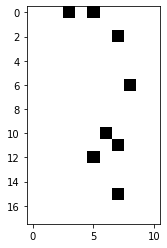

In [76]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(pic2>0.21, cmap='gray_r')
plt.show()